#  Predicting galaxy redshifts from 3D-HST

Last update June, 13 2023

## Setup environment

In [1]:
%%file requirements.txt
matplotlib
pandas
numpy
scikit-learn
tensorflow
torch
jax
jaxlib
flax
astropy
plotly
git+https://github.com/mfouesneau/ezdata

Overwriting requirements.txt


In [2]:
!python3 -m pip install -q -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Notebook setup

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as plt
from IPython.display import Markdown, display
from ezdata.matplotlib import light_minimal
plt.style.use(light_minimal)

## Predicting galaxy redshift via regression on 3D-HST photometry

### Download data

First, download the 3D-HST catalog from the MAST archive. This dataset is described in [Skelton et. al 2014](https://dx.doi.org/10.1088/0067-0049/214/2/24).

In [4]:
from astropy.utils.data import download_file
import tarfile
import os


if not os.path.isdir('3dhst_master.phot.v4.1'):
    file_url = 'https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/3dhst_master.phot.v4.1.tar'
    tarfile.open(download_file(file_url, cache=True), "r:")\
           .extract('3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat', '.')
else:
    print('file already downloaded.')

file already downloaded.


Read the combined photmetric catalog into a dataframe via astropy

In [6]:
import pandas as pd
fname = '3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat'
with open(fname, 'r') as fin:
    header = fin.readline()[1:]  #remove comment character
    df = pd.read_csv(fin, names=header.strip().split(), comment='#', delimiter='\s+')
df = df.set_index('id')

In [7]:
df

field          ra        dec         x         y  z_spec  z_peak  \
id                                                                          
1.0      AEGIS  215.222382  53.004185   9590.50   3057.30 -1.0000  0.0100   
2.0      AEGIS  215.096588  52.918053  16473.20   3150.20 -1.0000  0.0100   
3.0      AEGIS  215.161469  52.959461  13060.10   2982.30 -1.0000  0.2062   
4.0      AEGIS  215.305298  53.052921   5422.80   2692.10 -1.0000  0.0355   
5.0      AEGIS  215.041840  52.871273  19894.60   2834.40 -1.0000  0.3427   
...        ...         ...        ...       ...       ...     ...     ...   
44098.0    UDS   34.363106  -5.122067  14578.84  11076.42 -1.0000  0.1852   
44099.0    UDS   34.333569  -5.123219  16343.92  11007.12 -1.0000  0.6716   
44100.0    UDS   34.363682  -5.123123  14544.39  11013.01  1.4196  2.7489   
44101.0    UDS   34.556389  -5.123040   3028.23  11017.04 -1.0000  1.1716   
44102.0    UDS   34.365097  -5.121975  14459.90  11081.91 -1.0000  0.6160   

         faper_F140W  eaper_F140W  faper_F160W  ...  flags  f140w_flag  \
id                                              ...                      
1.0         -82.0410   -82.041000  22531.00000  ...      0           0   
2.0           3.5078     0.074233      3.99050  ...      3           0   
3.0          -1.9043    -1.904300      1.38110  ...      1           0   
4.0         -72.3250   -72.325000      0.82549  ...      0           0   
5.0        1890.5000     0.133300    -99.00000  ...      0           1   
...              ...          ...          ...  ...    ...         ...   
44098.0     188.8200     0.170750    -99.00000  ...      0           1   
44099.0       1.7193     0.129080    -99.00000  ...      0           1   
44100.0       1.3829     0.113830    -99.00000  ...      0           1   
44101.0     -99.0000   -99.000000      5.51670  ...      1           0   
44102.0       1.5335     0.152730    -99.00000  ...      0           1   

         star_flag  use_phot  near_star  nexp_f125w  nexp_f140w  nexp_f160w  \
id                                                                            
1.0              1         0          0           2           0           3   
2.0              0         0          0           4           4           4   
3.0              0         1          0           2           0           2   
4.0              0         0          0           1           0           1   
5.0              2         0          1           0           3           0   
...            ...       ...        ...         ...         ...         ...   
44098.0          2         0          0           0           3           0   
44099.0          2         0          0           0           3           0   
44100.0          2         0          0           0           4           0   
44101.0          0         0          0           1           0           2   
44102.0          2         0          0           0           3           0   

         lmass   Av  
id                   
1.0       7.51  1.1  
2.0       5.62  0.1  
3.0       9.00  1.1  
4.0       4.78  0.4  
5.0      11.57  0.5  
...        ...  ...  
44098.0  10.21  0.2  
44099.0   8.49  0.7  
44100.0   9.08  1.4  
44101.0  10.55  1.0  
44102.0   8.58  0.0  

[207967 rows x 37 columns]

### Exploring the dataset

Now we will examine the contents of the catalog. 

The dataset contains standard information such as target `id`, `field` name, coordinates (`ra`, `dec`), fluxes, uncertainties, and various photometric flags (see [Skelton et. al 2014](https://dx.doi.org/10.1088/0067-0049/214/2/24), or download the [README](https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/master_readme.v4.1.txt) here). 

In addition, there are some derived properties such as photometric redshift (`z_peak`), spectroscopic redshift (`z_spec`), mass (`lmass`) and dust extinction in the V band (`Av`).

[Kriek et al (2018; FAST)](https://ui.adsabs.harvard.edu/abs/2018ascl.soft03008K/abstract) describe the masse estimates.

**Keep in mind that we are interested in predicting redshift, so our "target" variable will be `z_spec`. The "features" will be all relevant columns.**

In [8]:
df.columns

Index(['field', 'ra', 'dec', 'x', 'y', 'z_spec', 'z_peak', 'faper_F140W',
       'eaper_F140W', 'faper_F160W', 'eaper_F160W', 'f_F606W', 'e_F606W',
       'f_F814W', 'e_F814W', 'f_F125W', 'e_F125W', 'f_F140W', 'e_F140W',
       'f_F160W', 'e_F160W', 'tot_cor', 'kron_radius', 'a_image', 'b_image',
       'flux_radius', 'fwhm_image', 'flags', 'f140w_flag', 'star_flag',
       'use_phot', 'near_star', 'nexp_f125w', 'nexp_f140w', 'nexp_f160w',
       'lmass', 'Av'],
      dtype='object')

### Cleaning the dataset

For our application, there are columns that we do not / should not use in making a model of redshift. Let's consider the following comments:

* we will drop the identifier, the field, x, y, ra, dec because we do not need to learn any anisotropy due to a limited survey. 

* we consider all fluxes, but note that the `faper_` fields correspond to somewhat duplicated measurements. Let's drop the latter fields.

* `nexp_` gives us the number of exposures, which does not seem important here.

* `tot_cor` corresponds to a flux (aperture) correction. 

* `kron_radius`, corresponds to a KRON radius, i.e. 90% of the flux contained in an aperture size twice that radius. `flux_radius` similarly corresponds to the half light radius. Let's remove those.

* `a_image` & `b_image`	correspond to semi-major and semi-minor axes

* `fwhm_image` corresponds to the Gaussian fit of the objects' cores. Not relevant for us.

* `star_flag` if 0, corresponds to galaxy. Any other value means star.

* `lmass` corresponds to the estimated mass of the quasar based on the redshift and luminosity. We must remove it to avoid data leakage.

* `Av` corresponds to the extinction along the line of sight. This may be helpful to keep to tell us about the reddening and dimming of a source.

* `use_phot` & `near_star` are flags about the detection and measurements. These could be interesting to use to get the best training set possible.

In [9]:
df.describe()

ra            dec              x              y  \
count  207967.000000  207967.000000  207967.000000  207967.000000   
mean      122.067472      14.465094   12156.481048   10233.742518   
std        73.831227      35.387678    7233.913627    5733.813482   
min        34.216633     -27.959742       7.400000    1273.020000   
25%        53.061646      -5.272032    7316.685000    6161.300000   
50%       150.091034       2.274822   10578.100000    8873.450000   
75%       189.306900      52.957975   15137.135000   13184.660000   
max       215.305298      62.388302   37668.900000   30753.300000   

              z_spec         z_peak    faper_F140W    eaper_F140W  \
count  207967.000000  207967.000000  207967.000000  207967.000000   
mean       -0.953653       1.177393     -15.424237     -22.113783   
std         0.489124       6.727479     323.776749      54.457811   
min       -99.900000     -99.000000    -482.630000    -482.630000   
25%        -1.000000       0.817400     -48.633500     -48.633500   
50%        -1.000000       1.415900       0.178810       0.069309   
75%        -1.000000       2.128050       0.491190       0.086337   
max         6.118000       5.960900   47052.000000   10592.000000   

         faper_F160W    eaper_F160W  ...          flags     f140w_flag  \
count  207967.000000  207967.000000  ...  207967.000000  207967.000000   
mean       13.392734      -0.518764  ...       0.500642       0.003303   
std       596.100221       7.605170  ...       1.278831       0.057380   
min       -99.000000     -99.000000  ...       0.000000       0.000000   
25%         0.186090       0.026516  ...       0.000000       0.000000   
50%         0.355380       0.035040  ...       0.000000       0.000000   
75%         0.939190       0.042530  ...       0.000000       0.000000   
max     91185.000000     474.560000  ...      23.000000       1.000000   

           star_flag       use_phot      near_star     nexp_f125w  \
count  207967.000000  207967.000000  207967.000000  207967.000000   
mean        1.310165       0.847005       0.044267       8.358509   
std         0.943662       0.359984       0.205687      10.919348   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       4.000000   
50%         2.000000       1.000000       0.000000       4.000000   
75%         2.000000       1.000000       0.000000       8.000000   
max         2.000000       1.000000       1.000000      91.000000   

          nexp_f140w     nexp_f160w          lmass             Av  
count  207967.000000  207967.000000  207967.000000  207967.000000  
mean        4.425048       9.051638       8.410625       0.318929  
std         9.310295      15.192599       1.511090       0.544946  
min         0.000000       0.000000      -1.000000      -1.000000  
25%         0.000000       4.000000       7.910000       0.000000  
50%         4.000000       4.000000       8.500000       0.100000  
75%         4.000000       8.000000       9.180000       0.500000  
max        84.000000     132.000000      14.630000       4.000000  

[8 rows x 36 columns]

Looking at the values, we see that some `zspec`, fluxes and `Av` values are negative, some fluxes are set to -99.0

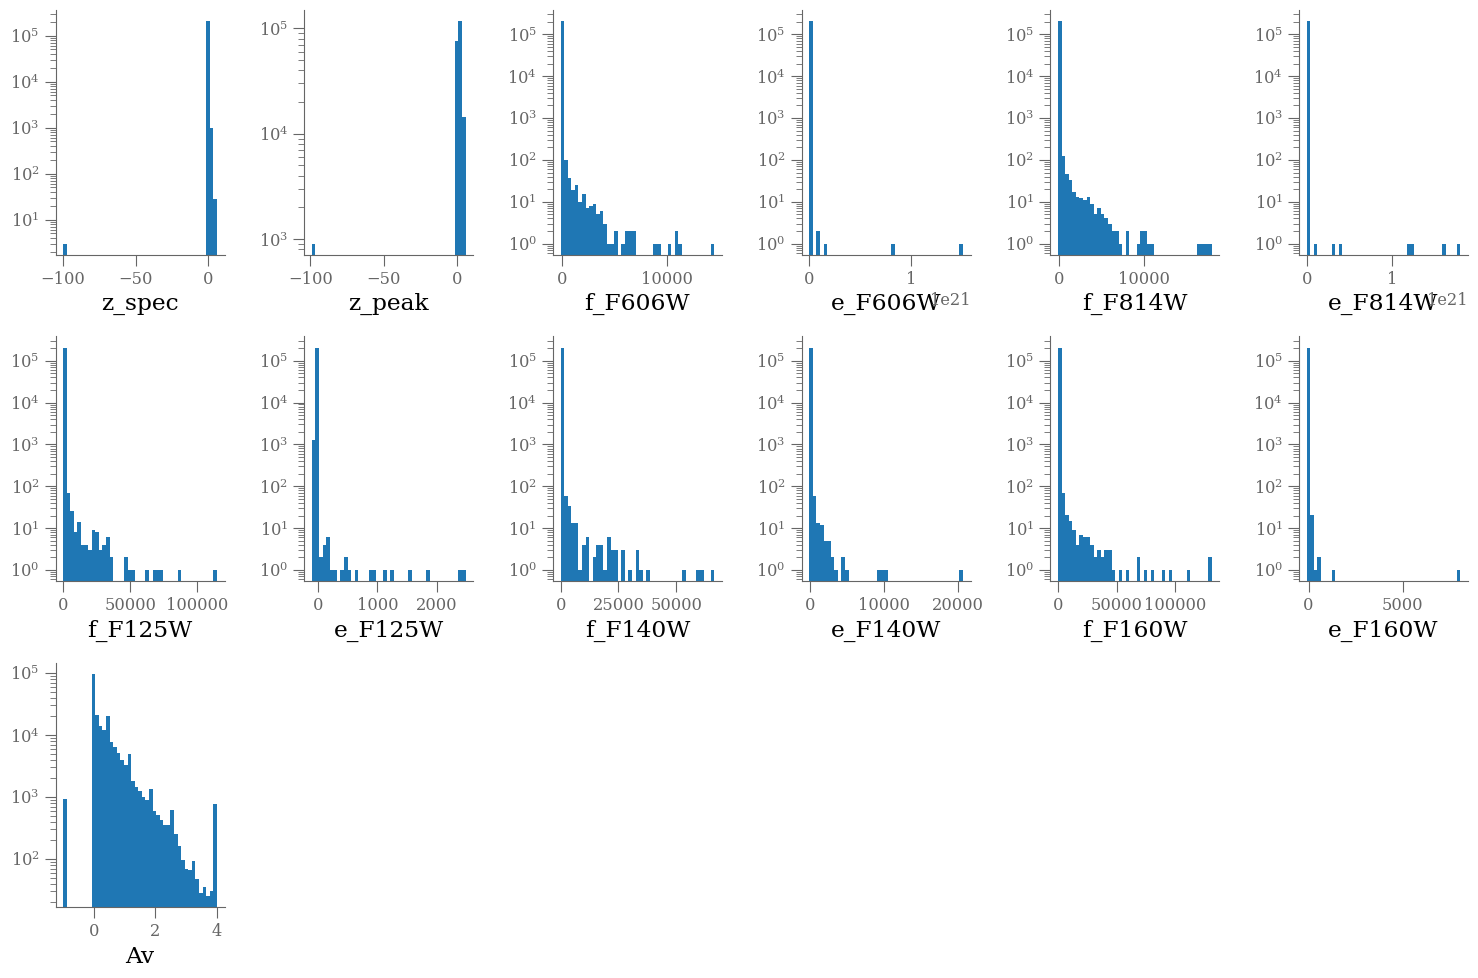

In [10]:
remove = ['field', 'ra', 'dec', 'x', 'y',
          'faper_F140W', 'eaper_F140W', 'faper_F160W', 'eaper_F160W',
          'tot_cor', 'kron_radius', 'a_image', 'b_image',
          'flux_radius', 'fwhm_image', 'flags', 'f140w_flag', 'star_flag',
          'use_phot', 'near_star', 'nexp_f125w', 'nexp_f140w', 'nexp_f160w',
          'lmass']

columns = [k for k in df.columns if k not in remove]

wrap = 6

plt.figure(figsize=(15, 10))

nlines = len(columns) // wrap +  int(len(columns) % wrap > 0) 

for e, colname in enumerate(columns, 1):
    plt.subplot(nlines, wrap, e)
    plt.hist(df[colname], bins=43, log=True)
    plt.xlabel(colname)

plt.tight_layout()

Text(0, 0.5, 'z spec')

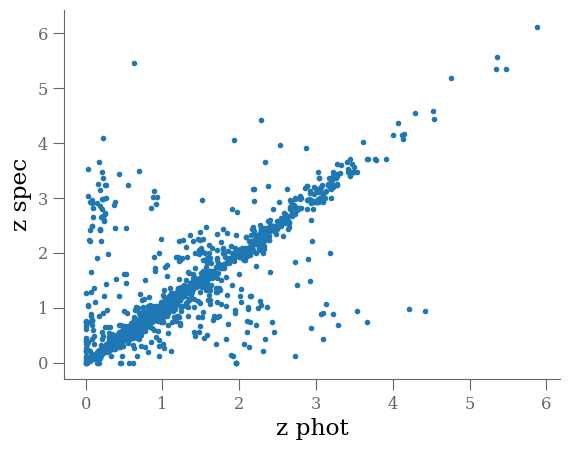

In [11]:
select = (df.z_peak > 0) & (df.z_spec > 0)
plt.plot(df[select].z_peak, df[select].z_spec, '.', rasterized=True)
plt.xlabel('z phot')
plt.ylabel('z spec')


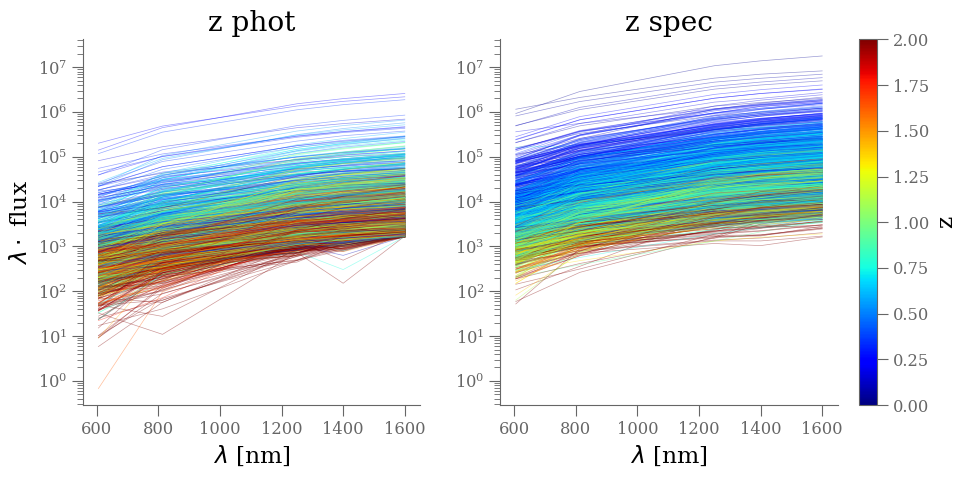

In [12]:
flux_cols = [name for name in df.columns if name.startswith('f_F')]
positive_flux = ' & '.join([f'({col:s} > 0)' for col in flux_cols])
x_ = np.array([606, 814, 1250, 1400, 1600])

select_zphot = '(star_flag == 0) & (use_phot == 1) & (z_peak > 0)'
select_zspec = '(star_flag == 0) & (z_spec > 0)'

cmap = plt.get_cmap('jet')
norm = plt.Normalize(vmin=0, vmax=2)


plt.figure(figsize=(10, 5))

ax = plt.subplot(121)
select = df.eval(select_zphot + '&' + positive_flux)
df_ = df[select]
ind = np.random.choice(len(df_), 2_000, replace=False)
X = df_[flux_cols].to_numpy()[ind]
y = df_['z_peak'].to_numpy()[ind]

for xk, yk in zip(X, y):
    color = cmap(norm(yk))
    plt.plot(x_, x_ * xk, color=color, rasterized=True, alpha=0.4, lw=0.5)

plt.yscale('log')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('z phot')
cbar.ax.set_visible(False)
plt.ylabel('$\lambda  \cdot $ flux')
plt.xlabel('$\lambda$ [nm]')
plt.title('z phot')


plt.subplot(122,  sharex=ax, sharey=ax)
select = df.eval(select_zspec + '&' + positive_flux)
df_ = df[select]
ind = np.random.choice(len(df_), 2_000, replace=False)
X = df_[flux_cols].to_numpy()[ind]
y = df_['z_spec'].to_numpy()[ind]
for xk, yk in zip(X, y):
    color = cmap(norm(yk))
    plt.plot(x_, x_ * xk, color=color, rasterized=True, alpha=0.4, lw=0.5)
plt.yscale('log')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('z')
plt.title('z spec')

plt.xlabel('$\lambda$ [nm]')

plt.tight_layout()

In [13]:
remove = ['field', 'ra', 'dec', 'x', 'y',
          'faper_F140W', 'eaper_F140W', 'faper_F160W', 'eaper_F160W',
          'tot_cor', 'kron_radius', 'a_image', 'b_image',
          'flux_radius', 'fwhm_image', 'flags', 'f140w_flag', 'star_flag',
          'use_phot', 'near_star', 'nexp_f125w', 'nexp_f140w', 'nexp_f160w',
          'lmass']

flux_cols = [name for name in df.columns if name.startswith('f_F')]

positive_flux = ' & '.join([f'({col:s} > 0)' for col in flux_cols])

select_zphot = '(star_flag == 0) & (use_phot == 1) & (z_peak > 0) & (Av >= 0)'
select_zspec = '(star_flag == 0) & (z_spec > 0) & (Av >= 0)'

In [14]:
select = df.eval(select_zspec + '&' + positive_flux)
df_ = df[select].reset_index()
target = 'z_spec'
# features = [col for col in df_ if col not in remove + ['z_spec', 'z_peak'] ]
features = flux_cols + ['Av']

Markdown(f"""
**features** {features}

**target**: {target} """)


**features** ['f_F606W', 'f_F814W', 'f_F125W', 'f_F140W', 'f_F160W', 'Av']

**target**: z_spec 

In [15]:
df_x = pd.concat([df_[[fk for fk in features if fk not in flux_cols]], 
                  np.log10(df_[flux_cols]).rename(columns={k: k.replace('f_', 'm_') for k in flux_cols})], 
                  axis=1)
df_y = df_[target]

In [16]:
df_x

Av   m_F606W   m_F814W   m_F125W   m_F140W   m_F160W
0     0.1  0.797247  0.975064  1.086893  1.152105  1.172282
1     1.2  0.686877  0.881835  1.191004  1.271934  1.350558
2     0.6  0.997478  1.173245  1.281374  1.307410  1.333185
3     0.1  0.537932  1.090822  1.508880  1.572964  1.636698
4     0.7  1.157608  1.335598  1.491544  1.531849  1.576698
...   ...       ...       ...       ...       ...       ...
2287  0.6  0.310247  1.097466  1.719588  1.794063  1.881316
2288  0.6  2.120245  2.233580  2.333165  2.319252  2.425632
2289  0.6  0.960361  1.216166  1.435717  1.483602  1.520156
2290  1.4  2.104111  2.280373  2.507032  2.561006  2.613112
2291  0.7  1.553167  1.690878  1.855410  1.884246  1.910507

[2292 rows x 6 columns]

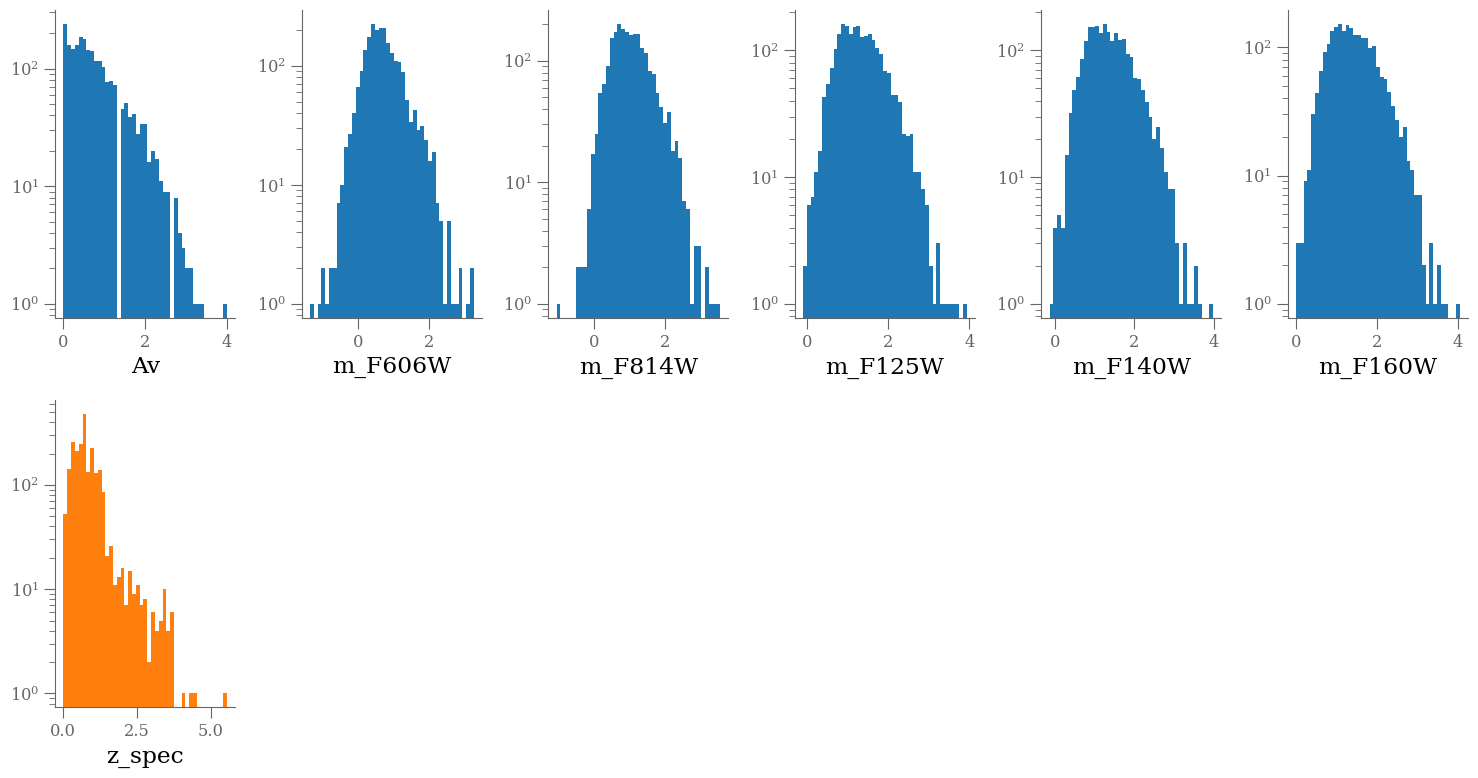

In [17]:
columns = [k for k in df_x.columns]

wrap = 6

nlines = (len(columns) + 1) // wrap +  int((len(columns) + 1) % wrap > 0)

plt.figure(figsize=(15, nlines * 4))
for e, colname in enumerate(columns, 1):
    plt.subplot(nlines, wrap, e)
    plt.hist(df_x[colname], bins=43, log=True)
    plt.xlabel(colname)

plt.subplot(nlines, wrap, e + 1)
plt.hist(df_y, bins=43, log=True, color='C1')
plt.xlabel(target)

plt.tight_layout()

### Divide the data into train, test and validation sets

Note that typically one needs to pass arrays to the common libraries. 

```python
X = df[features].values
y = df[target].values
```

However, `Scikit-learn` has implemented pandas interfaces, so we do not need to do so in this particular exercise.



Divide the data into train, validation and test sets. We will use the following definitions:

* **Training**: The data used to update model parameters (e.g., coefficients or matrix element values).

* **Validation**: The data used to update model selection (for instance, we might change hyperparameters of a model based on the validation metrics).

* **Testing**: The data used to make final predictions, and possibly evaluate the final model score.

In [18]:
from sklearn.model_selection import train_test_split

# first reserve 70% of the data for training, 30% for validation
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)

### Explore regression models

Here we explore a few options for regressor models.

#### Linear Regression 

Let's do a simple one first

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
lin = LinearRegression()
lin.fit(X_train, y_train)

LinearRegression()

To quantify the performance of the model, we will apply it to the validation set and compare the predicted values with the true values by computing the mean squared error:

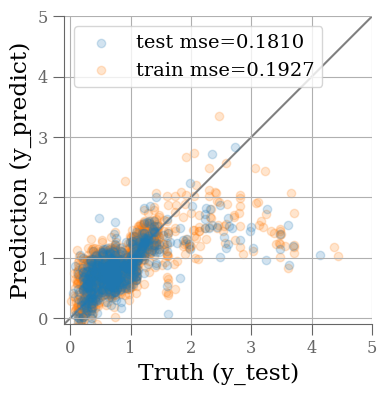

In [21]:
from sklearn.metrics import mean_squared_error

y_predict = lin.predict(X_test)
y_predict0 = lin.predict(X_train)
mse_train = mean_squared_error(y_train, y_predict0)
mse_test = mean_squared_error(y_test, y_predict)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label=f'test mse={mse_test:0.4f}')
ax.scatter(y_train, y_predict0, alpha=0.2, label=f'train mse={mse_train:0.4f}', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='upper left')

The MSE is not great. Not surprising given the simplicity of our model. Maybe we can do better changing the model?



Text(0.5, 0, 'Lin. Coeffs')

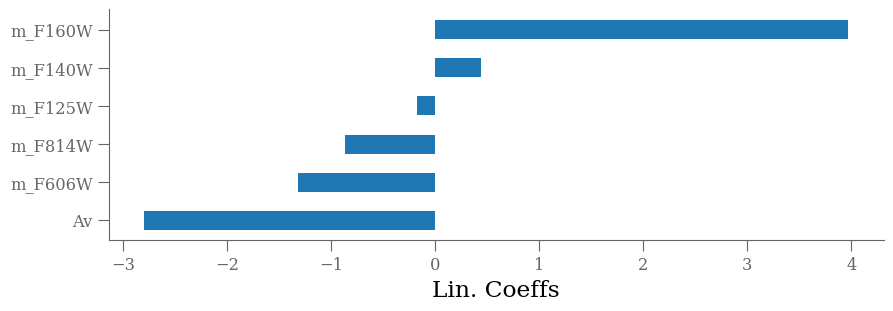

In [22]:
importances = lin.coef_
labels = lin.feature_names_in_
argsort = np.argsort(importances)
fig = plt.figure(figsize=[10, len(labels) * 0.5])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_x.columns)), importances[argsort], 
        align='center', 
        height=0.5, 
        tick_label=labels)
ax.set_xlabel("Lin. Coeffs")

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoLarsIC

pipe = Pipeline([
    ('polynomial', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('classifier', LassoLarsIC(normalize=True))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('classifier', LassoLarsIC(normalize=True))])

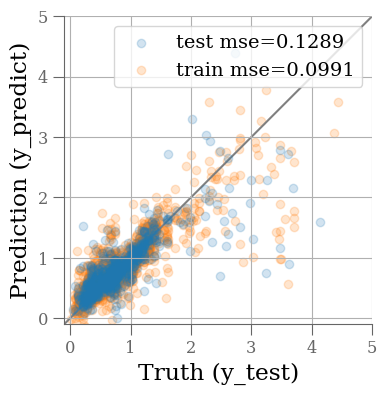

In [24]:
y_predict = pipe.predict(X_test)
y_predict0 = pipe.predict(X_train)
mse_train = mean_squared_error(y_train, y_predict0)
mse_test = mean_squared_error(y_test, y_predict)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label=f'test mse={mse_test:0.4f}')
ax.scatter(y_train, y_predict0, alpha=0.2, label=f'train mse={mse_train:0.4f}', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')

Text(0.5, 0, 'Lin. Coeffs')

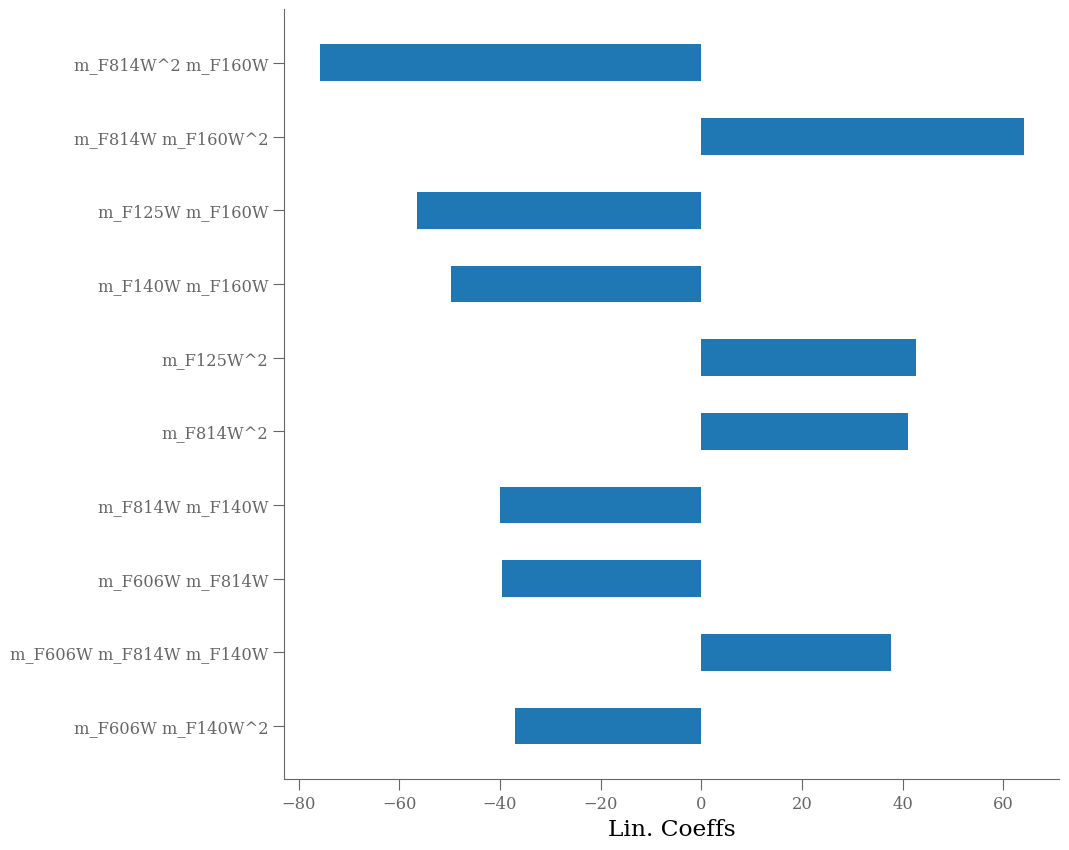

In [25]:
importances = pipe['classifier'].coef_
labels = pipe['polynomial'].get_feature_names_out()
argsort = np.argsort(np.abs(importances))[-10:]

importances = importances[argsort]
labels = labels[argsort]

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(labels)), importances, 
        align='center', 
        height=0.5, 
        tick_label=labels)
ax.set_xlabel("Lin. Coeffs")

#### Other models

Using sklearn, it is very easy to change a model for something different.

#### Random Forest

Using sklearn, we can very easily construct a decision tree model for regressing redshift from the photometric catalog features. A decision tree is composed of a series of if-else decision steps. The number of steps and the types of decision at each step is determined by training the algorithm with supervision. In this first example, we will use the DecisionTreeRegressor from sklearn.

In [26]:
from sklearn.ensemble import RandomForestRegressor

# use the same parameters as the Decision Tree
params = {
    "min_samples_split": 15,
    "min_samples_leaf": 5,
    "max_depth": 15,
}

# Initialize the model
rf = RandomForestRegressor(**params)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=15)

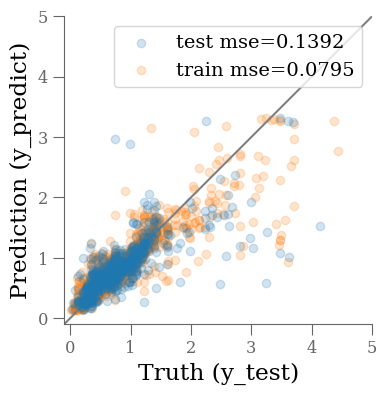

In [27]:
y_predict = rf.predict(X_test)
y_predict0 = rf.predict(X_train)
mse_train = mean_squared_error(y_train, y_predict0)
mse_test = mean_squared_error(y_test, y_predict)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label=f'test mse={mse_test:0.4f}')
ax.scatter(y_train, y_predict0, alpha=0.2, label=f'train mse={mse_train:0.4f}', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')

The results are much improved by the random forest! 

However, we must be cautious. It is possible that this model suffers from **over-fitting**. To visualize overfitting, we can compare the mean squared error (MSE) for models of increasing max_depth on the training and testing sets:

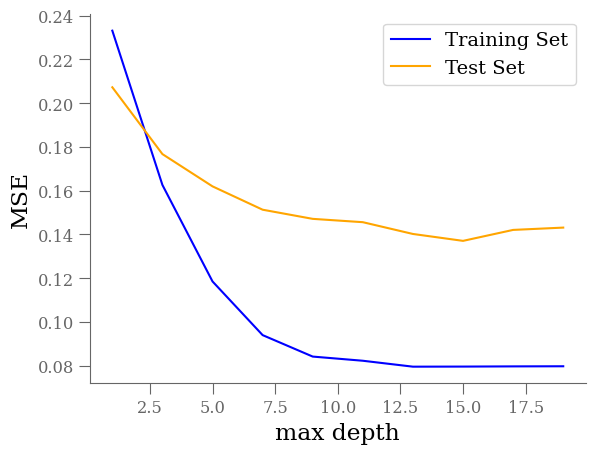

In [28]:
max_depths = np.arange(1, 20, 2).astype(int)

train_mse = []
test_mse = []

params = {
    "min_samples_split": 15,
    "min_samples_leaf": 5,
}

for depth in max_depths:

    rff_ = RandomForestRegressor(max_depth=depth, **params)
    rff_.fit(X_train, y_train)
    
    y_predict_train = rff_.predict(X_train)
    y_predict_test = rff_.predict(X_test)
    
    train_mse.append(mean_squared_error(y_train, y_predict_train))
    test_mse.append(mean_squared_error(y_test, y_predict_test))

    
fig, ax = plt.subplots(1, 1)

ax.plot(max_depths, train_mse, color='blue', label='Training Set')
ax.plot(max_depths, test_mse, color='orange', label='Test Set')
ax.set_xlabel('max depth')
ax.set_ylabel('MSE')
ax.legend()

Beyond a max_depth of ~10, the MSE on the training set declines while the MSE on the test set flattens out, suggesting some amount of over-fitting.

To explore further, we will explore how general our model performance (here quantifed with MSE) is using k-fold cross-validation via sklearn. In practice, the X and y datasets are split into k “folds”, and over k iterations, the model is trained using k-1 folds as training data and the remaining fold as a test set to compute performace (i.e., MSE).

In [29]:
from sklearn.model_selection import cross_validate

cv = cross_validate(
    estimator=rf, 
    X=df_x, 
    y=df_y, 
    cv=5, # number of folds
    scoring='neg_mean_squared_error'
)

print(f'Cross-validated score: {cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}')

Cross-validated score: -0.156 +/- 0.089


The previous MSE is consistent with the cross-validated MSE, suggesting that the model is not significantly over-fitting.

Next, we’ll observe which features are most important to the model predictions.

Text(0.5, 0, 'Feature importance')

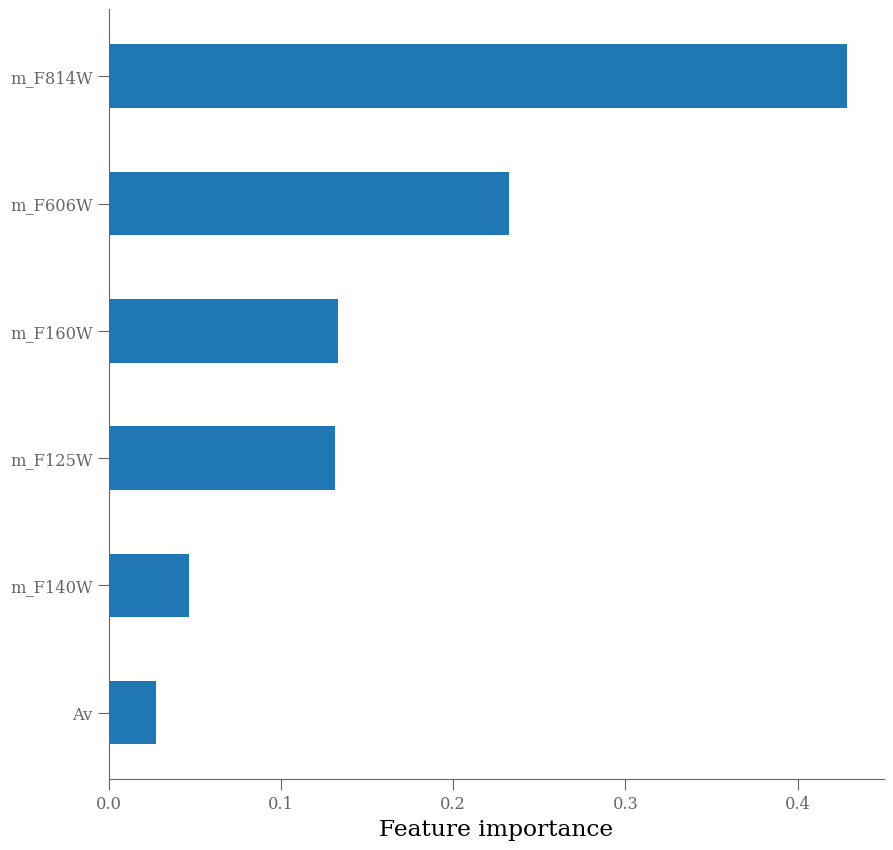

In [30]:
importances = rf.feature_importances_
argsort = np.argsort(importances)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_x.columns)), importances[argsort], 
        align='center', 
        height=0.5, 
        tick_label=np.array(df_x.columns)[argsort])
ax.set_xlabel("Feature importance")

#### Extratrees

In [31]:
from sklearn.ensemble import HistGradientBoostingRegressor


# Initialize the model
et = HistGradientBoostingRegressor()

et.fit(X_train, y_train)

HistGradientBoostingRegressor()

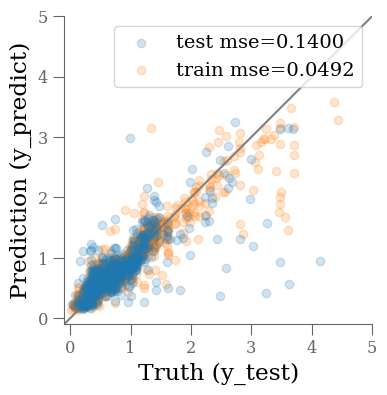

In [32]:
y_predict = et.predict(X_test)
y_predict0 = et.predict(X_train)
mse_train = mean_squared_error(y_train, y_predict0)
mse_test = mean_squared_error(y_test, y_predict)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label=f'test mse={mse_test:0.4f}')
ax.scatter(y_train, y_predict0, alpha=0.2, label=f'train mse={mse_train:0.4f}', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')

In [33]:
cv = cross_validate(
    estimator=et, 
    X=df_x, 
    y=df_y, 
    cv=5, # number of folds
    scoring='neg_mean_squared_error'
)

print(f'Cross-validated score: {cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}')

Cross-validated score: -0.154 +/- 0.088


In [34]:
pipe2 = Pipeline([
    ('polynomial', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('classifier', HistGradientBoostingRegressor())
])

pipe2.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('classifier', HistGradientBoostingRegressor())])

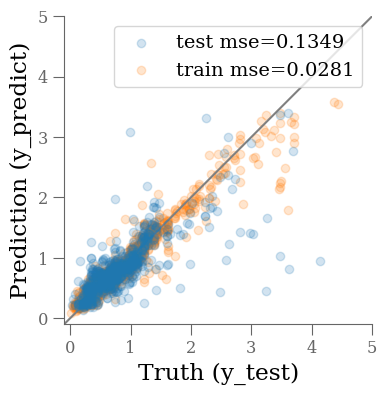

In [35]:
y_predict = pipe2.predict(X_test)
y_predict0 = pipe2.predict(X_train)
mse_train = mean_squared_error(y_train, y_predict0)
mse_test = mean_squared_error(y_test, y_predict)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label=f'test mse={mse_test:0.4f}')
ax.scatter(y_train, y_predict0, alpha=0.2, label=f'train mse={mse_train:0.4f}', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')

#### Check against each other and reference

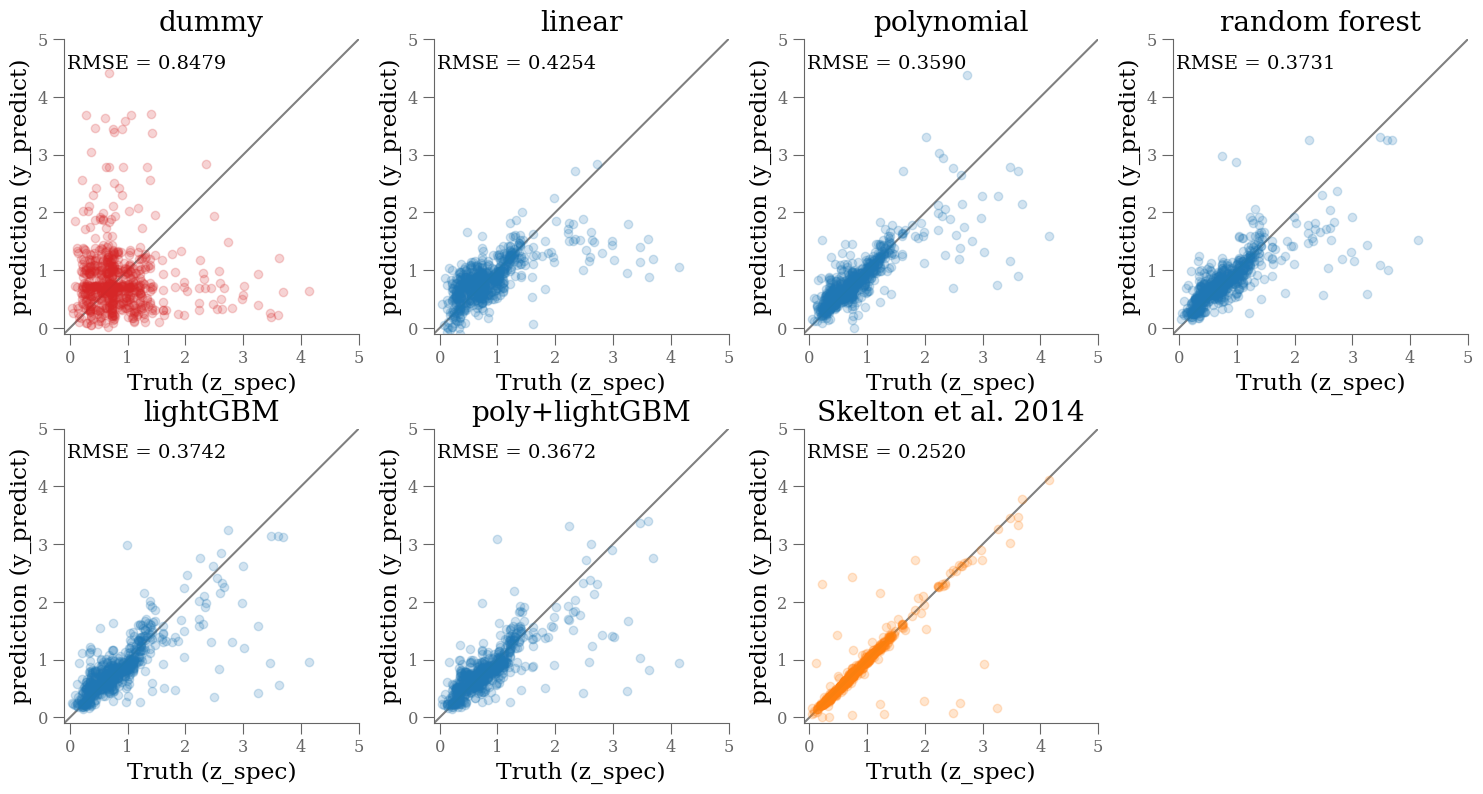

In [36]:
n, bins = np.histogram(y_train, bins=256)
cdf = n.cumsum()
z_cdf = 0.5 * (bins[:-1] + bins[1])
yval = np.interp(np.random.uniform(0, 1, len(y_test)),
                 cdf / cdf[-1], bins[:-1])

y_values = [yval[:], 
            lin.predict(X_test),
            pipe.predict(X_test),
            rf.predict(X_test),
            et.predict(X_test),
            pipe2.predict(X_test),
            df_['z_peak'].loc[y_test.index]
]

names = ['dummy', 'linear', 'polynomial', 'random forest', 'lightGBM', 'poly+lightGBM', 'Skelton et al. 2014']

wrap = 4

nlines = (len(columns) + 1) // wrap +  int((len(columns) + 1) % wrap > 0)

# plt.figure(figsize=(15, nlines * 4))

fig, axes = plt.subplots(nlines, wrap, figsize=(15, 4 * nlines))

for k, (ax, yval) in enumerate(zip(np.ravel(axes), y_values)):
    color = 'C0'
    if k == len(names) - 1:
        color = 'C1'
    if k == 0:
        color='C3'
    ax.scatter(y_test, yval, alpha=0.2, color=color)
    ax.set_aspect('equal')
    ax.set_xlim(-0.1, 5)
    ax.set_ylim(-0.1, 5)
    ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
    ax.set_xlabel('Truth (z_spec)')
    ax.set_ylabel('prediction (y_predict)')
    ax.set_title(names[k])
    mse = mean_squared_error(y_test, yval, squared=False)
    ax.text(0.01, 0.9, f'RMSE = {mse:.4f}', transform=ax.transAxes)
plt.setp(np.ravel(axes)[k+1:], visible=False)

plt.tight_layout()

### Going further

* What if you include galaxy colors (e.g., F125W-F140W, F140W-F160W, F606W-F125W)? do the model results improve? Can you think of other features to include?

* Can you tune the model parameters with a grid search? 

* What if you try other models from sklearn?

### Neural Networks

In [37]:
from typing import Sequence
import torch

class linearRegressionNN(torch.nn.Module):
    def __init__(self, n_input: int, 
                 n_hidden: Sequence[int], 
                 n_output: int):
        super().__init__()
    
        self.sequence = torch.nn.Sequential()
        # add input layer
        self.sequence.add_module("input", 
                                 torch.nn.Linear(n_input, n_hidden[0]))
        # set hidden layers
        for e, (n1, n2) in enumerate(zip(n_hidden[:-1], n_hidden[1:])):
            self.sequence.add_module(f"hidden_{e:d}", 
                                     torch.nn.Linear(n1, n2))
            self.sequence.add_module(f"activation_{e:d}", 
                                     torch.nn.SELU())
        # set output layer    
        self.sequence.add_module("output",  
                                 torch.nn.Linear(n_hidden[-1], n_output))

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return self.sequence(x)

criterion = torch.nn.MSELoss()

/shared-libs/python3.10/py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
model = linearRegressionNN(len(features), [32] * 4, 1)
optimizer = torch.optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = torch.nn.MSELoss()
epochs = 6_000

# always be careful to normalize your data.
x_scaler = StandardScaler()
X_scaled = np.squeeze(x_scaler.fit_transform(X_train))
inputs = torch.from_numpy(X_scaled.astype('float32'))
labels = torch.from_numpy(y_train.to_numpy().astype('float32').reshape(-1, 1))
inputs_test = torch.from_numpy(x_scaler.transform(X_test).astype('float32'))
labels_test = torch.from_numpy(y_test.to_numpy().astype('float32').reshape(-1, 1))

# monitoring
loss_list = []
history = [] 

for epoch in range(epochs):
    # Clear gradient buffers because we don't want any gradient 
    # from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)
    outputs_test = model(inputs_test)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    loss_test = criterion(outputs_test, labels_test)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch {}, loss {:2.4g} {:2.4g}'.format(epoch, loss.item(), loss_test.item()))
    history += [[epoch, float(loss), float(loss_test)]]    
    #scheduler.step()

print(f"Epoch= {epoch},\t loss = {loss:2.4g} {loss_test:2.4g}")
print('done.')

epoch 0, loss 1.256 1.194
epoch 100, loss 0.2532 0.2278
epoch 200, loss 0.2139 0.1975
epoch 300, loss 0.2004 0.1835
epoch 400, loss 0.1863 0.1683
epoch 500, loss 0.1766 0.1581
epoch 600, loss 0.1671 0.1524
epoch 700, loss 0.1582 0.1492
epoch 800, loss 0.1512 0.148
epoch 900, loss 0.1441 0.1448
epoch 1000, loss 0.135 0.1381
epoch 1100, loss 0.1252 0.1304
epoch 1200, loss 0.1153 0.1273
epoch 1300, loss 0.1071 0.1248
epoch 1400, loss 0.09918 0.1177
epoch 1500, loss 0.09319 0.1151
epoch 1600, loss 0.08701 0.1111
epoch 1700, loss 0.08287 0.1121
epoch 1800, loss 0.07684 0.1062
epoch 1900, loss 0.0748 0.102
epoch 2000, loss 0.07119 0.1002
epoch 2100, loss 0.0688 0.09899
epoch 2200, loss 0.06734 0.09871
epoch 2300, loss 0.06555 0.09761
epoch 2400, loss 0.06401 0.09789
epoch 2500, loss 0.06564 0.09763
epoch 2600, loss 0.06504 0.1043
epoch 2700, loss 0.06077 0.09725
epoch 2800, loss 0.06038 0.09661
epoch 2900, loss 0.06069 0.09704
epoch 3000, loss 0.05867 0.09635
epoch 3100, loss 0.05673 0.09808

Text(0, 0.5, 'loss MSE')

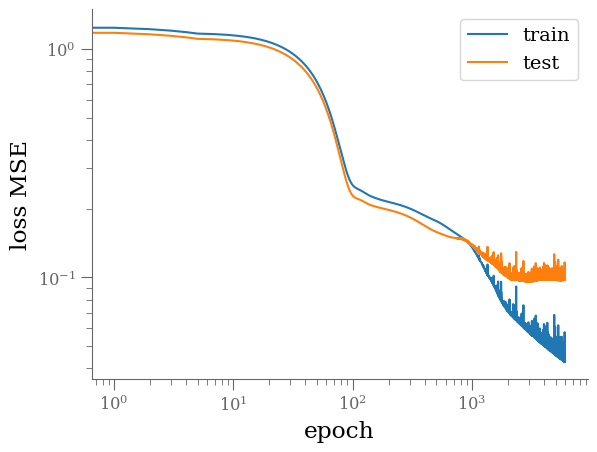

In [44]:
plt.loglog([e for (e, l, _) in history], 
           [float(l) for (e, l, _) in history], '-', label='train')
plt.loglog([e for (e, _, l) in history], 
           [float(l) for (e, _, l) in history], '-', label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss MSE')

In [45]:
y_predict = model(
    torch.from_numpy(x_scaler.transform(X_test).astype('float32'))
    ).cpu().detach().numpy()  
y_predict0 = model(
    torch.from_numpy(x_scaler.transform(X_train).astype('float32'))
    ).cpu().detach().numpy()  

RMSE = 0.3148


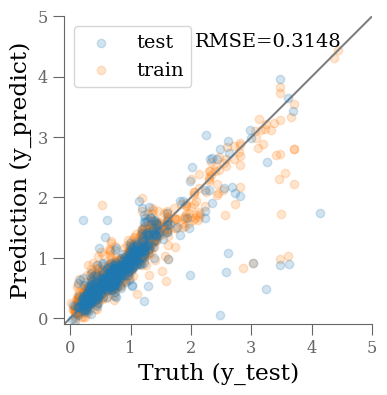

In [46]:
mse = mean_squared_error(y_test, y_predict, squared=False)
print(f'RMSE = {mse:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label='test')
ax.scatter(y_train, y_predict0, alpha=0.2, label='train', zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color='0.5')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('Prediction (y_predict)')
plt.legend(loc='best')
ax.text(0.9, 0.9, f"RMSE={mse:0.4f}", transform=ax.transAxes, ha='right');